In [4]:
from fastai2.vision.all import *
import sys
sys.path.append('..')

In [5]:
from modules.trainutils import piece_class_parse

In [25]:
test_path = Path('../../../other-chess-data/regulation-pieces-1/crops')
train_path = Path('../../../rf-chess-data/cropped_v1/')
modelconfig_path = Path('../models/model-config')

In [26]:
train_dl = ImageDataLoaders.from_name_func(
                train_path, 
                get_image_files(train_path),
                # stratify_sample(train_path, n=n, np_seed=seed),
                valid_pct=0.2, 
                seed=42,
                label_func=piece_class_parse, 
                item_tfms=Resize(128, method='crop',),
                batch_tfms=aug_transforms(max_lighting=0.95),
                bs=32,
)

In [27]:
test_dl = ImageDataLoaders.from_name_func(
                test_path, 
                get_image_files(test_path),
                # stratify_sample(train_path, n=n, np_seed=seed),
                valid_pct=0.2, 
                seed=42,
                label_func=piece_class_parse, 
                item_tfms=Resize(128, method='crop',),
                batch_tfms=aug_transforms(mult=0),
                bs=32,
)

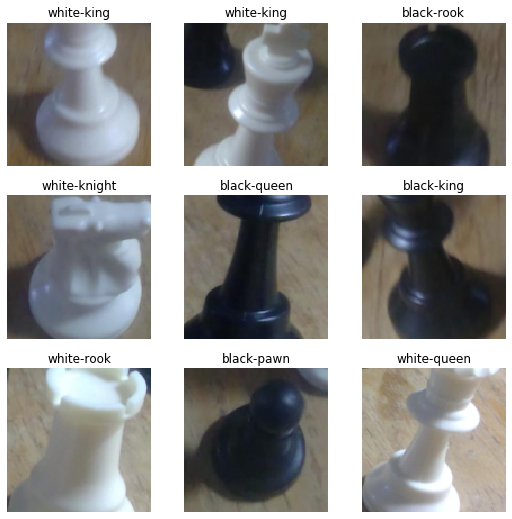

In [28]:
test_dl.show_batch()

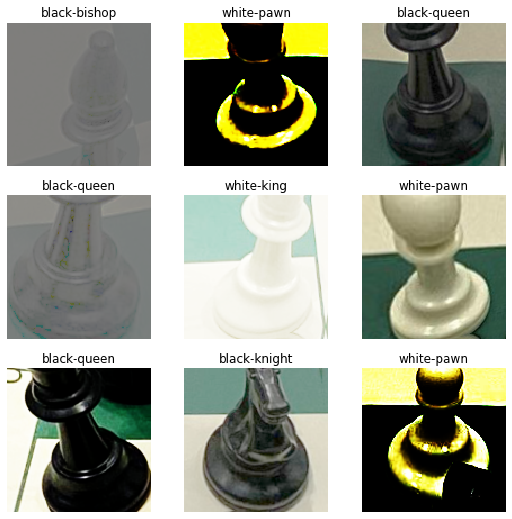

In [13]:
train_dl.show_batch()

### Setup Transform Objects
There are two main image types we work with: PILImage and TensorImage. 

Usually the first step in a get_x pipeline for a dataloader in to read in from PIL and convert to tensor.


In [206]:
img_fn = train_dl.train.items[3]

In [207]:
img_old = Image.open(img_fn)

In [208]:
img = PILImage(PILImage.create(img_fn).resize((600,400)))

In [ ]:
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
def _batch_ex(bs): 
    return TensorImage(timg[None].expand(bs, *timg.shape).clone())

b = _batch_ex(1)

In [247]:
PILImage, PILImageBW, 

(fastai2.vision.core.PILImage, fastai2.vision.core.PILImageBW)

In [248]:
type(b), type(img), type(img_old)

(fastai2.torch_core.TensorImage,
 fastai2.vision.core.PILImage,
 PIL.JpegImagePlugin.JpegImageFile)

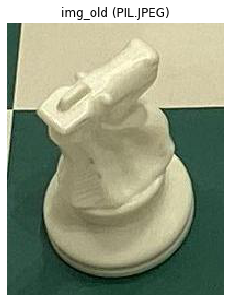

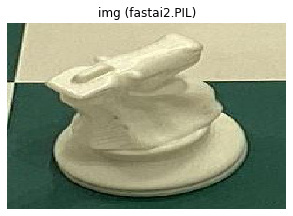

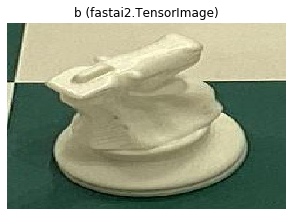

In [259]:
show_image(img_old, title='img_old (PIL.JPEG)');
show_image(img, title=('img (fastai2.PIL)'))
show_image(b[0], title='b (fastai2.TensorImage)')

### Demo some Transforms
For many transforms, there TensorImage.method() methods to apply them.

We're also interesting in setting up the full class so we write our own.

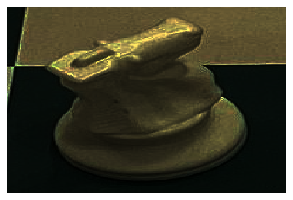

In [253]:
show_image(b.brightness(draw=0.1)[0])

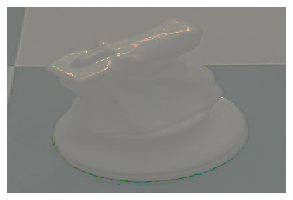

In [262]:
show_image(b.contrast(draw=0.1)[0])

In [264]:
rsz = Resize(128, method='pad', pad_mode='zeros')

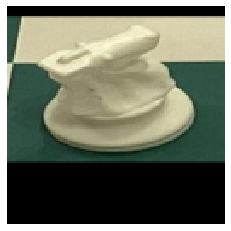

In [265]:
show_image(rsz(img))

### Examine Transform Class objects in detail

In [278]:
pp_train_dl = train_dl.dl

In [279]:
pp_train_dl

Pipeline: PILBase.create

In [281]:
output = pp_train_dl(img_fn)
type(output)

fastai2.vision.core.PILImage

In [284]:
train_dl.train.tfms[0]

Pipeline: PILBase.create

In [286]:
train_dl.train_ds.tfms[0]

Pipeline: PILBase.create

In [291]:
pp_train_dl[1]

PILBase.create: (bytes,object) -> create
(ndarray,object) -> create
(Tensor,object) -> create
(str,object) -> create
(Path,object) -> create 

In [292]:
tmp_learn = load_learner('../models/stadard-piece-2.pkl')

In [314]:
pp_learn_train = tmp_learn.dls.train.after_batch

In [315]:
pp_learn_train

Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm -> Normalize

In [316]:
tmp_learn.dls.train.after_item

Pipeline: RandomResizedCrop -> ToTensor

### Chaining Exisiting Pipelines

In [333]:
king_fn = '../../../other-chess-data/regulation-pieces-1/crops/00000_white-knight.jpg'

In [334]:
pp_after_item = train_dl.train.after_item
pp_tfms = train_dl.train.tfms[0]

In [336]:
pp_after_item, pp_tfms

(Pipeline: Resize -> ToTensor, Pipeline: PILBase.create)

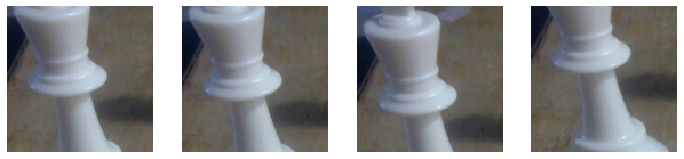

In [346]:
fig,axs = plt.subplots(1,4, figsize=(12,3))
for i, ax in enumerate(axs.flatten()):
    show_image(pp_after_item(pp_tfms(king_fn)), ctx=ax)

In [349]:
resize_in_pp = pp_after_item[0]

In [352]:
resize_in_pp.size, resize_in_pp.method

((128, 128), 'crop')

True

### Build my own pipeline

In [363]:
pp_tfms[1].name

'PILBase.create'

In [366]:
my_pipe = Pipeline([  #PILBase.create, 
                    Resize(128, method='pad'), 
                    ToTensor()])

In [378]:
my_pipe2 = Pipeline([pp_tfms[0],
                    pp_tfms[1],
                    Resize(128, method='pad'), 
                    ToTensor()])

In [383]:
my_pipe3 = Pipeline([pp_tfms[0],
                    PILImage.create,
                    Resize(128, method='pad'), 
                    ToTensor()])

In [384]:
my_pipe4 = Pipeline([noop,
                    pp_tfms[1],
                    Resize(128, method='pad'), 
                    ToTensor()])

In [ ]:
my_pipe4 = Pipeline([noop,
                    pp_tfms[1],
                    Resize(128, method='pad'), 
                    ToTensor()])

In [387]:
my_pipe5 = Pipeline([
                    pp_tfms[1],
                    Resize(128, method='pad'), 
                    ToTensor()])

In [386]:
pp_tfms[1].name

'PILBase.create'

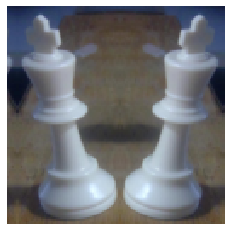

In [389]:
show_image(my_pipe4(king_fn))

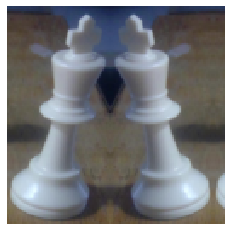

In [380]:
show_image(my_pipe2(king_fn))

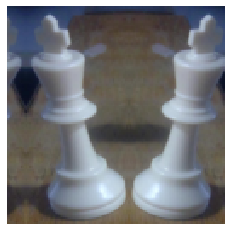

In [368]:
show_image(my_pipe(pp_tfms(king_fn)))

### Make a new class

In [406]:
from fastai2.vision.augment import RandTransform
from fastai2.vision.augment import _process_sz, _get_sz

In [431]:
class MyResizeRand(RandTransform):
    split_idx = None
    mode,mode_mask,order,final_size = Image.BILINEAR,Image.NEAREST,1,None
    "Resize image to `size` using `method`"
    def __init__(self, size, method=ResizeMethod.Crop, pad_mode=PadMode.Reflection,
                 resamples=(Image.BILINEAR, Image.NEAREST), **kwargs):
        super().__init__(**kwargs)
        self.size,self.pad_mode,self.method = _process_sz(size),pad_mode,method
        self.mode,self.mode_mask = resamples

    def before_call(self, b, split_idx):
        if self.method==ResizeMethod.Squish: return
        self.pcts = (0.5,0.5) if split_idx else (random.random(), random.random())

    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        orig_sz = _get_sz(x)
        self.final_size = self.size
        if self.method==ResizeMethod.Squish:
            return x.crop_pad(orig_sz, Tuple(0,0), orig_sz=orig_sz, pad_mode=self.pad_mode,
                   resize_mode=self.mode_mask if isinstance(x,PILMask) else self.mode, resize_to=self.size)

        w,h = orig_sz
        op = (operator.lt,operator.gt)[self.method==ResizeMethod.Pad]
        m = w/self.size[0] if op(w/self.size[0],h/self.size[1]) else h/self.size[1]
        cp_sz = (int(m*self.size[0]),int(m*self.size[1]))
        tl = Tuple(int(self.pcts[0]*(w-cp_sz[0])), int(self.pcts[1]*(h-cp_sz[1])))
        print(tl)
        return x.crop_pad(cp_sz, tl, orig_sz=orig_sz, pad_mode=self.pad_mode,
                   resize_mode=self.mode_mask if isinstance(x,PILMask) else self.mode, resize_to=self.size)

class MyResizeDeterm(RandTransform):
    split_idx = None
    mode,mode_mask,order,final_size = Image.BILINEAR,Image.NEAREST,1,None
    "Resize image to `size` using `method`"
    def __init__(self, size, method=ResizeMethod.Crop, pad_mode=PadMode.Reflection,
                 resamples=(Image.BILINEAR, Image.NEAREST), **kwargs):
        super().__init__(**kwargs)
        self.size,self.pad_mode,self.method = _process_sz(size),pad_mode,method
        self.mode,self.mode_mask = resamples

    def before_call(self, b, split_idx):
        if self.method==ResizeMethod.Squish: return
        self.pcts = (0.5,0.5) if split_idx else (0., 0.)

    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        orig_sz = _get_sz(x)
        self.final_size = self.size
        if self.method==ResizeMethod.Squish:
            return x.crop_pad(orig_sz, Tuple(0,0), orig_sz=orig_sz, pad_mode=self.pad_mode,
                   resize_mode=self.mode_mask if isinstance(x,PILMask) else self.mode, resize_to=self.size)

        w,h = orig_sz
        op = (operator.lt,operator.gt)[self.method==ResizeMethod.Pad]
        m = w/self.size[0] if op(w/self.size[0],h/self.size[1]) else h/self.size[1]
        cp_sz = (int(m*self.size[0]),int(m*self.size[1]))
        tl = Tuple(int(self.pcts[0]*(w-cp_sz[0])), int(self.pcts[1]*(h-cp_sz[1])))
        print(tl)
        return x.crop_pad(cp_sz, tl, orig_sz=orig_sz, pad_mode=self.pad_mode,
                   resize_mode=self.mode_mask if isinstance(x,PILMask) else self.mode, resize_to=self.size)


In [432]:
rand_pipe = Pipeline([
                MyResizeRand(128, method='crop'), 
                ToTensor()])

dete_pipe = Pipeline([
                MyResizeDeterm(128, method='crop'), 
                ToTensor()])

(0, 449)
(0, 216)
(0, 514)
(0, 269)


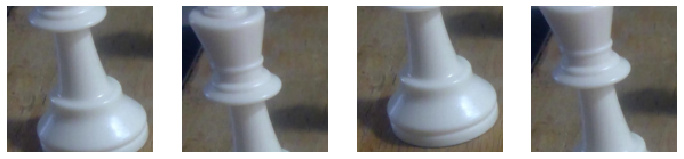

In [433]:
fig,axs = plt.subplots(1,4, figsize=(12,3))
for i, ax in enumerate(axs.flatten()):
    show_image(rand_pipe(pp_tfms(king_fn)), ctx=ax)

(0, 0)
(0, 0)
(0, 0)
(0, 0)


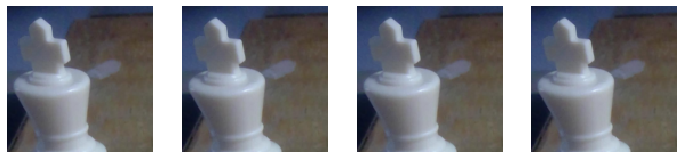

In [434]:
fig,axs = plt.subplots(1,4, figsize=(12,3))
for i, ax in enumerate(axs.flatten()):
    show_image(dete_pipe(pp_tfms(king_fn)), ctx=ax)

In [435]:
king_np = np.array(Image.open(king_fn))

In [439]:
king_np.shape

(983, 465, 3)

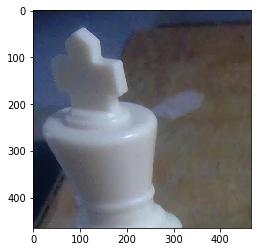

In [438]:
plt.imshow(king_np[:465,:,:])

In [443]:
from modules.tfmsutils import MyResizeDeterm as MRD

In [444]:
mrd_pipe = Pipeline([
                MRD(128, method='crop'), 
                ToTensor()])

(0, 0)
(0, 0)
(0, 0)
(0, 0)


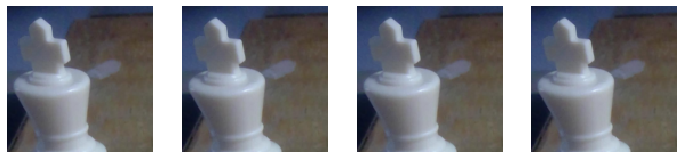

In [445]:
fig,axs = plt.subplots(1,4, figsize=(12,3))
for i, ax in enumerate(axs.flatten()):
    show_image(mrd_pipe(pp_tfms(king_fn)), ctx=ax)

### Tip & Tricks

In [ ]:
# cool one - if you need to do the transform in numpy
#            e.g. with opencv imgt's 
#            then wrap convert into np, t, and back into PIL
aug = ShiftScaleRotate(p=1)
def aug_tfm(img): 
    np_img = np.array(img)
    aug_img = aug(image=np_img)['image']
    return PILImage.create(aug_img)